In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def define_files():
    fname = '1_MCKNZ_1h_20170101_201701*'
    meshmaskname = '1_mesh_mask.nc'

    vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
    vosaline_ref_profile = vosaline_ref[0, :, 0, 0]
    
    return fname, meshmaskname, vosaline_ref_profile

def get_displace(dirname, dep_ind_slice, time_s, flag):
    
    fname, meshmaskname, vosaline_ref_profile = define_files()
    
    time_f = time_s+24
        
    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, dep_ind_slice, time_s, time_f, None)

    if flag == 'full':
        
        vosaline_daily = upwelling_functions.get_daily_vosaline(vosaline, tmask, None)

        depth_ind_daily = upwelling_functions.get_daily_depth_ind(vosaline_daily, vosaline_ref_profile)
        depth_m_daily, displace = upwelling_functions.get_daily_depth_m(deptht, dep_ind_slice, depth_ind_daily, tmask)

        print(displace.min(), displace.max())
    
    else:
        displace, deptht = np.nan, np.nan
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
    
    return displace, deptht, e1t, e2t

#deptht[1], deptht[9], deptht[13] = 13.125, 83.125, 118.125

In [3]:
def plot_upwelling(ax, up_filename):
    up = np.loadtxt(up_filename, delimiter=",")
    cm_times = np.linspace(0, 1, int(up.shape[0]*1.4))
    colors = [cmo.cm.matter(x) for x in cm_times]
    for i, c in zip(np.arange(up.shape[0]), colors[len(colors)-up.shape[0]:]):
        this_up = up[i, 1:]
        this_dep = up[i, 0]
        ax.plot(this_up, c=c, lw=2, marker='.', ms=8, label=str(int(np.round(this_dep, 0))))
    ax.set_xlabel('Time [hours]', fontsize=20)
    ax.set_ylabel('Maximum upward\ndisplacement [m]', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0, 10*24, 12))
    min_x, max_x, min_y, max_y = 0, 132, 0, 200
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    ax.grid()
    leg = ax.legend(loc=4, ncol=5, fontsize=17)
    leg.set_title(title='final depth [m]', prop = {'size':20})
    ax.tick_params(axis='both', which='both', length=0, labelsize=15)
    ind_y, ind_x = 160, 3.5
    ax.add_patch(patches.Rectangle((min_x, ind_y), (ind_x-min_x),(max_y-ind_y),
                                   fc='#C5C6CB', ec='#8F9491', lw=1.5, alpha=1))
    ax.annotate('j', xy=(1.5,178),
                fontsize=30, weight='normal', va='center', ha='center')
    return ax

In [4]:
def plot_panels(kind, dirname, dep_ind_slice_all, time_s_day_all):
    
    datafilename = './files/displace_'+kind+'.nc'
#     dataset = Dataset(datafilename, 'w') #--------file
#     file_x = dataset.createDimension('x', 272)
#     file_y = dataset.createDimension('y', 242)
    
    x_left, y_bottom = 205.822543591543,24.85159075988878
   
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(5, 4, width_ratios=[1,1,1,0.1], height_ratios=[1,1,1,0.2,0.5])
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1], sharex=ax1, sharey=ax1)
    ax3 = plt.subplot(gs[0, 2], sharex=ax1, sharey=ax1)
    axc0 = plt.subplot(gs[0, 3])

    ax4 = plt.subplot(gs[1, 0], sharex=ax1, sharey=ax1)
    ax5 = plt.subplot(gs[1, 1], sharex=ax1, sharey=ax1)
    ax6 = plt.subplot(gs[1, 2], sharex=ax1, sharey=ax1)
    axc1 = plt.subplot(gs[1, 3])

    ax7 = plt.subplot(gs[2, 0], sharex=ax1, sharey=ax1)
    ax8 = plt.subplot(gs[2, 1], sharex=ax1, sharey=ax1)
    ax9 = plt.subplot(gs[2, 2], sharex=ax1, sharey=ax1)
    axc2 = plt.subplot(gs[2, 3])
        
    if kind == 'ideal':
        mid = 306
    elif kind == 'real':
        mid = 400
    min_x, max_x, min_y, max_y = mid-100, mid+100, 25, 200
    ax1.set_xlim([min_x, max_x])
    ax1.set_ylim([min_y, max_y])
    
    for ax in ([ax1, ax2, ax3, ax4, ax5, ax6]):
        ax.xaxis.set_tick_params(labelbottom=False)
    for ax in ([ax2, ax3, ax5, ax6, ax8, ax9]):
        ax.yaxis.set_tick_params(labelbottom=False)
        
    fig.tight_layout()
    
    axoff = plt.subplot(gs[3,:])
    axoff.axis('off')
    axlong = plt.subplot(gs[4,:])
    
    if kind == 'ideal':
        vmins = [0, -20, -10]
        vmaxs = [120, 120, 140]
        levels = [-5, 5, 20, 40, 60]
    if kind == 'real':
        vmins = [-10, -20, 0]
        vmaxs = [40, 100, 100]
        levels = [-5, 5, 20, 40, 60]
        
    rows = [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]]
    axcs = [axc0, axc1, axc2]
    labs = [['a','b','c'], ['d','e','f'], ['g','h','i']]

    for row in range(3):
        vmin = vmins[row]
        vmax = vmaxs[row]
        ticks = np.arange(-20, vmax+20, 20)
        
        for col in range(3):
            
            ax = rows[row][col]
            
            ind_y = 180
            ind_y_mid = ind_y + (max_y-ind_y)*0.5
            ax.add_patch(patches.Rectangle((min_x, ind_y),(max_y-ind_y),(max_y-ind_y),
                                           fc='#C5C6CB', ec='#8F9491', lw=1.5, alpha=1))
            ax.annotate(labs[row][col], xy=(min_x+(max_y-ind_y)*0.5, ind_y_mid),
                        fontsize=30, weight='normal', va='center', ha='center')
            ttl = 'Hours '+str(time_s_day_all[col]+1)+'-'+str(time_s_day_all[col]+24+1)
            
#             displace, deptht, e1t, e2t = get_displace(dirname, dep_ind_slice_all[row], time_s_day_all[col], 'full')
            nan1, nan2, e1t, e2t = get_displace(dirname, dep_ind_slice_all[row], time_s_day_all[col], None)
                      
            varname = 'disp_z'+str(int(deptht[dep_ind_slice_all[row]]))+'_t'+str(time_s_day_all[col])
            print(varname)
            displace = nc.Dataset(datafilename)[varname][:]#--------file
#             var = dataset.createVariable(varname, 'f8', ('y','x'))
#             var[:] = displace[:]
#             print('saved file', varname)#--------file

            cmap, norm = cmo.cm.delta_r, upwelling_functions.MidpointNormalize(midpoint=0)
            cmap.set_bad('#8b7765')

            x_shift, y_shift = x_left+e1t, y_bottom+e2t

            p = ax.pcolormesh(x_shift, y_shift, displace, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
            cs = ax.contour(x_shift, y_shift, displace, levels=levels, colors='k', alpha=0.7, linewidths=0.5)
            ax.clabel(cs, inline=1, fontsize=15, fmt ='%1.f', colors='k')
            
            ax.tick_params(axis='both', which='both', length=0, labelsize=15)
            ax.set_aspect(aspect='equal')

            if row==0: ax.set_title(ttl, fontsize=25, y=1.08)
            else: pass

            if row==2: ax.set_xlabel('Alongshore (x)\ndistance [m]', fontsize=20)
            else:pass

            if col==0:
                ax.set_ylabel('Cross-shore (y)\ndistance [m]', fontsize=20)
                ax.annotate('Depth = '+str(int(np.round(deptht[dep_ind_slice_all[row]],0)))+'m',
                            xy=(0, 0.5), xytext=(-90, 0),
                            xycoords=('axes fraction'), textcoords='offset points',
                            size=25, ha='center', va='center', rotation='vertical')
            else: pass

            if col==2:
                cbar_lab = 'Vertical displacement [m]'
                cbar = fig.colorbar(p, cax=axcs[row], orientation='vertical', fraction=5.0, aspect=15, pad=5.8)
                cbar.ax.tick_params(labelsize=20)
                cbar.set_ticklabels(ticks)
                cbar.set_ticks(ticks)
                cbar.ax.set_ylabel(cbar_lab, rotation=270, fontsize=20)
                cbar.ax.get_yaxis().labelpad = 30   

    if kind == 'ideal':
        up_filename = './files/upwelling_ideal_base.out'
    elif kind == 'real':
        up_filename = './files/upwelling_real_base.out'
    ax = plot_upwelling(axlong, up_filename)
    
    fig.patch.set_facecolor('white')    
    plt.subplots_adjust(top=0.99, wspace=0.05, hspace=0.08)
    
#     dataset.close() #--------file
    return fig 

# Ideal

In [5]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, 9, 1, 10, None)

time_s_day1 = 24*0 + 11# day 1
time_s_day2 = 24*1 + 11# day 2
time_s_day4 = 24*3 + 11# day 4


time_s_day_all = [time_s_day1, time_s_day2, time_s_day4]
dep_ind_slice_all = [1, 9, 18]

disp_z13_t11
disp_z13_t35
disp_z13_t83
disp_z83_t11
disp_z83_t35
disp_z83_t83
disp_z161_t11
disp_z161_t35
disp_z161_t83


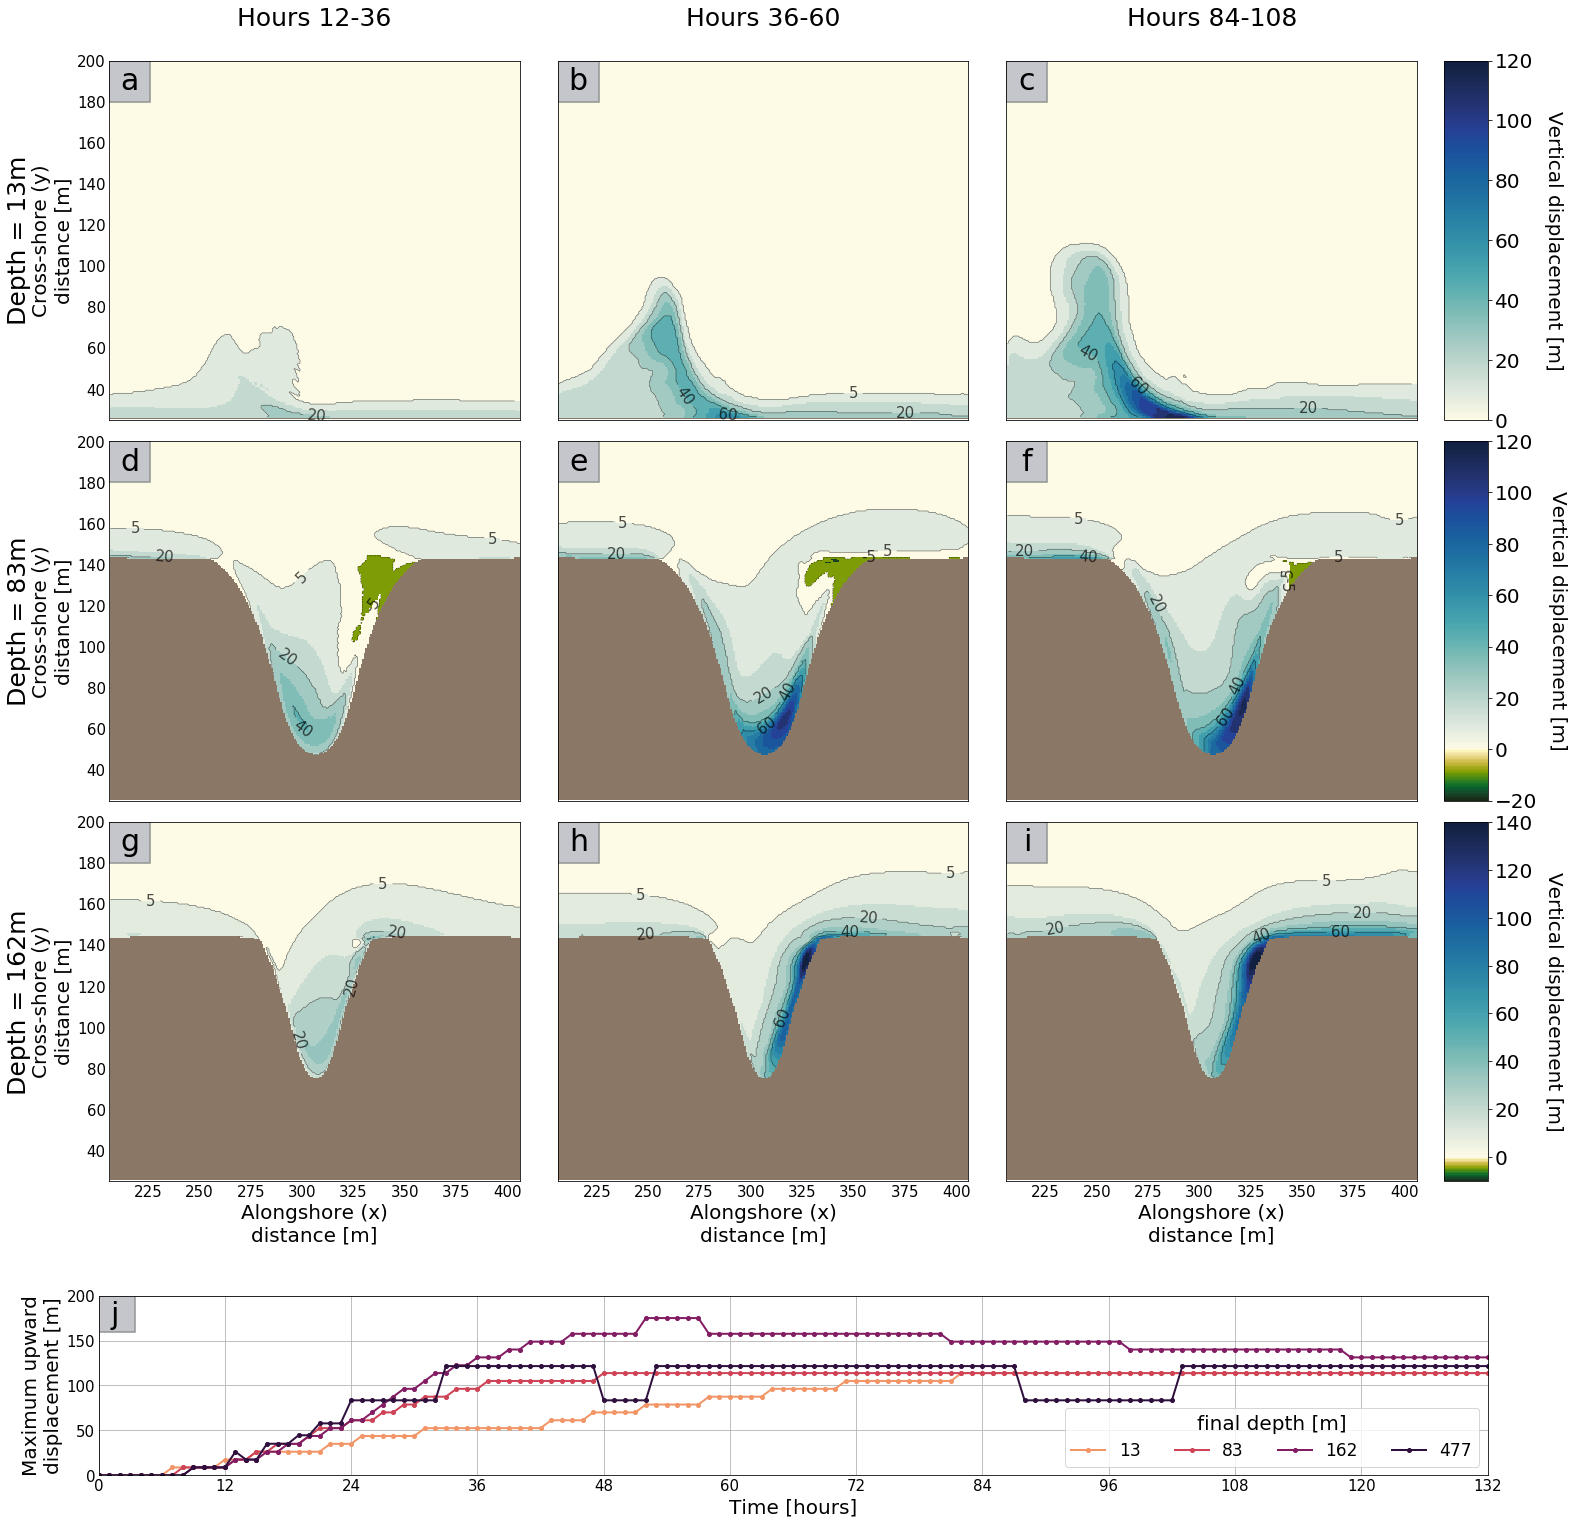

In [6]:
fig = plot_panels(kind, dirname, dep_ind_slice_all, time_s_day_all)
fig.savefig('./fig_displacement_ideal.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

# Real